In [25]:
%matplotlib inline
import cv2
import os
import numpy as np
import glob
import keras
import h5py
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from matplotlib import pyplot as plt

## Load in images

In [26]:
unblocked_images = []
for img in glob.glob("ProjectAbby/img/unblocked/*.png"):
    n= cv2.imread(img, flags=cv2.IMREAD_ANYDEPTH)
    unblocked_images.append(n)

In [27]:
unblocked_images = np.array(unblocked_images)

In [28]:
unblocked_images.shape

(362, 480, 752)

In [29]:
blocked_images_all = []
for img in glob.glob("ProjectAbby/img/blocked/*/*.png"):
    n = np.array(cv2.imread(img, flags=cv2.IMREAD_ANYDEPTH))
    blocked_images_all.append(n)

In [30]:
blocked_images_all = np.array(blocked_images_all)

In [31]:
blocked_images_all.shape

(354, 480, 752)

In [32]:
len(blocked_images_all) / (len(blocked_images_all) + len(unblocked_images))

0.49441340782122906

In [33]:
np.max(blocked_images_all)

37924

## Create X and y arrays (input and output) and shuffle them

In [34]:
y_unblocked = np.full(len(unblocked_images), 0)
y_blocked = np.full(len(blocked_images_all), 1)
y_all = np.concatenate((y_unblocked, y_blocked))

In [35]:
X_all = np.concatenate((unblocked_images, blocked_images_all), axis=0)

In [36]:
X_all.shape

(716, 480, 752)

In [37]:
shuf_ind = np.random.permutation(len(y_all))
X_all = X_all[shuf_ind].reshape((len(y_all),X_all.shape[1],X_all.shape[2],1))
y_all = y_all[shuf_ind]

X_all.shape

(716, 480, 752, 1)

In [38]:
np.median(X_all)

10000.0

In [39]:
print(np.max(X_all))
X_all[X_all == 10000] = 40000
print(np.max(X_all))

37924
40000


In [40]:
X_all = (40000 - X_all)
X_all = X_all / 40000
X_all

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [41]:
np.max(X_all)

0.9926

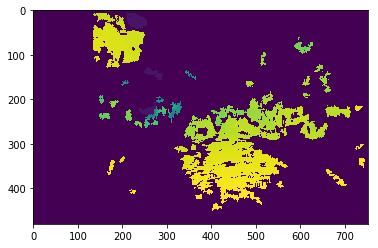

In [42]:
plt.imshow((X_all[0]).reshape((480,752)))

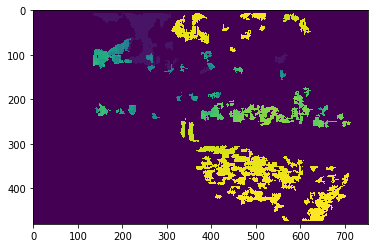

In [43]:
plt.imshow((X_all[600]).reshape((480,752)))

## Set up model and train

In [51]:
model = keras.Sequential([
    keras.layers.Conv2D(16, (4,4), activation='relu', input_shape=(X_all.shape[1],X_all.shape[2], 1)),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(4, (4,4), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.MaxPool2D((2, 2)),
    #
    keras.layers.Flatten(),  
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

ValueError: Input 0 is incompatible with layer conv2d_7: expected ndim=4, found ndim=3

In [45]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
model.fit(X_all, y_all, validation_split=0.2, epochs=20, batch_size=16)

Train on 572 samples, validate on 144 samples
Epoch 1/20
572/572 [==============================] - 103s 179ms/step - loss: 0.5858 - accuracy: 0.6958 - val_loss: 0.4196 - val_accuracy: 0.8056
Epoch 2/20
572/572 [==============================] - 95s 166ms/step - loss: 0.3548 - accuracy: 0.8601 - val_loss: 0.3889 - val_accuracy: 0.8056
Epoch 3/20
572/572 [==============================] - 85s 149ms/step - loss: 0.2548 - accuracy: 0.9091 - val_loss: 0.2659 - val_accuracy: 0.8819
Epoch 4/20
572/572 [==============================] - 86s 150ms/step - loss: 0.1221 - accuracy: 0.9545 - val_loss: 0.3490 - val_accuracy: 0.8681
Epoch 5/20
572/572 [==============================] - 85s 148ms/step - loss: 0.0519 - accuracy: 0.9895 - val_loss: 0.3559 - val_accuracy: 0.9028
Epoch 6/20
572/572 [==============================] - 84s 146ms/step - loss: 0.0471 - accuracy: 0.9843 - val_loss: 0.3598 - val_accuracy: 0.9097
Epoch 7/20
572/572 [==============================] - 83s 146ms/step - loss: 0.0084

KeyboardInterrupt: 

## Save model and weights

In [47]:
# serialize model to JSON
model_json = model.to_json()
with open("blocked_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("blocked_model.h5")
print("Saved model to disk")

Saved model to disk


In [52]:
model.predict(X_all[9].reshape((1,480,752,1)))

array([[0.9999232]], dtype=float32)

In [53]:
X_all[0].reshape((1,480,752,1))

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]])